We had a client advising they are having issues with enpoint timing out. Requested from the client was timeout thresholds for this particular endpoint.

The following script will code a program that will help build/gauge the best timeout parameter's for this endpoint based on the current data. Please see details further below.

# Build a program that will test server request response time using Requests library elapsed property.


- Use a pubic testing endpoint
- Code this model using Python Requests object
- Extract the elapsed time disussed below and cross compare over model testing 
- Input this into pandas dataframe and visually analyse our findings


In [1]:
import numpy as np
import pandas as pd

import json # Python built-in package json for encoding and decoding JSON data.
import requests # library for working with HTTP requests in Python

from requests.exceptions import Timeout
from requests.adapters import HTTPAdapter
from requests.exceptions import ConnectionError

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

Next, we will discuss some key concepts when using Python's request library.

### API Performance Analysis

Requests Elapsed Time Proprty

The response object returned by post|get requests has a property called elapsed, which provides the time delta between when the request was sent and when the response was received. We can apply total_seconds() method to return this time in seconds. This is useful for testing threshold for our timeout parameter.

#### Sessions
Sessions object from the Request library enables us to control how requests are being made or to improve the performance of your requests, you may need to use a Session instance directly. Sessions are used to persist parameters across requests. The primary performance optimization of sessions comes in the form of persistent connections. When your app makes a connection to a server using a Session, it keeps that connection around in a connection pool. When your app wants to connect to the same server again, it will reuse a connection from the pool rather than establishing a new one.

MAX RETRIES

When a request fails, you may want your application to retry the same request. However, requests will not do this for you by default. To apply this functionality, you need to implement a custom Transport Adapter.

Transport Adapters let you define a set of configurations per service you’re interacting with. 

#### Timeouts

When you make an inline request to an external service, your system will need to wait upon the response before moving on. If your application waits too long for that response, requests to your service could back up, your user experience could suffer, or your background jobs could hang.

By default, requests will wait indefinitely on the response, so you should almost always specify a timeout duration to prevent these things from happening. To set the request’s timeout, use the timeout parameter. timeout can be an integer or float representing the number of seconds to wait on a response before timing out.

NOTE

You can also pass a tuple to timeout with the first element being a connect timeout (the time it allows for the client to establish a connection to the server), and the second being a read timeout (the time it will wait on a response once your client has established a connection)

## Model Building
Pre-define data structure for both extracting data and controling the the total number of tests using a counter variable. 

NOTE

We have declared a counter variable manually which will control the number of tests we will run. We could use Python's collectios library for this task.

In [2]:
# Generate list data 1 - x for each individual test 
tests=[] # empty list
for i in range(0,50,1): # range(start,stop.step)
    tests.append(i) # append (add) items to list

# Pre-defined data structures to extract model data
request_times = [] # UTC request time (note list data structure to maintain order of our data)
elapsed_times_test_1 = [] # server response time

# Emply counter variable which will act as our model test threhold value ie. when the model will stop running
counter = 0

Model Testing 

In [3]:
url = "https://api.coindesk.com/v1/bpi/currentprice.json"
set_adapter = HTTPAdapter(max_retries = 3) # Build Transport Adapter, input max_retries parameter, and mount it to an existing Session:
time = (0.1,0.15) # connection timeout (connect,read) seconds

for test in tests:
    if counter <= len(tests):
        counter += 1
        print("Test :",counter)
        
        #
        with requests.Session() as session:
            session.mount(url, set_adapter)
            try:
                #
                response = session.get(url, timeout=time)
                dt_request = datetime.now() # Getting the current date and time request executed/processes (time will be close to time server was hit for request)
                request_times.append(dt_request)
                timestamp = datetime.timestamp(dt_request) # Getting the timestamp (time will be close to time server was hit for request)
                #
                response.raise_for_status() # check if succesfull repsonse code
                print("Request-Status-Code : {}".format(response.raise_for_status)) # get request status code
                print("Server Request Date | Time (UTC) : ", dt_request)
                
                #
                print()
                print("Requests-Proporty-Server-Repsonse-Time-Seconds",response.elapsed.total_seconds()) # requests property elapsed returns delta between request sent and response receieved
                time = response.elapsed.total_seconds()
                elapsed_times_test_1.append(time)
                print()
                
                #
            except requests.exceptions.ConnectionError as error:
                raise SystemExit(error)
            except requests.exceptions.HTTPError as error:
                raise SystemExit(error)


Test : 1
Request-Status-Code : <bound method Response.raise_for_status of <Response [200]>>
Server Request Date | Time (UTC) :  2023-11-19 19:56:00.806867

Requests-Proporty-Server-Repsonse-Time-Seconds 0.159682

Test : 2
Request-Status-Code : <bound method Response.raise_for_status of <Response [200]>>
Server Request Date | Time (UTC) :  2023-11-19 19:56:00.879006

Requests-Proporty-Server-Repsonse-Time-Seconds 0.070118

Test : 3
Request-Status-Code : <bound method Response.raise_for_status of <Response [200]>>
Server Request Date | Time (UTC) :  2023-11-19 19:56:00.945847

Requests-Proporty-Server-Repsonse-Time-Seconds 0.064013

Test : 4
Request-Status-Code : <bound method Response.raise_for_status of <Response [200]>>
Server Request Date | Time (UTC) :  2023-11-19 19:56:01.013938

Requests-Proporty-Server-Repsonse-Time-Seconds 0.065046

Test : 5
Request-Status-Code : <bound method Response.raise_for_status of <Response [200]>>
Server Request Date | Time (UTC) :  2023-11-19 19:56:01.

Below we will input our extracted data into a pandas dataframe and build this into a visualization. 

In [8]:
# Create DataFrame using dictionariy data sturcutre and dataframe method
threshold = pd.DataFrame ({'Request Time UTC':request_times,'Server Request Response Time Seconds':elapsed_times_test_1})
threshold.head()

,Request Time UTC,Server Request Response Time Seconds
0,2023-11-19 19:56:00.806867,0.159682
1,2023-11-19 19:56:00.879006,0.070118
2,2023-11-19 19:56:00.945847,0.064013
3,2023-11-19 19:56:01.013938,0.065046
4,2023-11-19 19:56:01.083637,0.066702


In [5]:
# dataframe descriptive statistics
threshold.describe()

,Server Request Response Time Seconds
count,50.000000
mean,0.071270
std,0.023195
min,0.057644
25%,0.062322
50%,0.063964
75%,0.067603
max,0.187575


[Text(0.5, 1.0, 'Testing Server Timeout Parameters - Threshold Evaluation')]

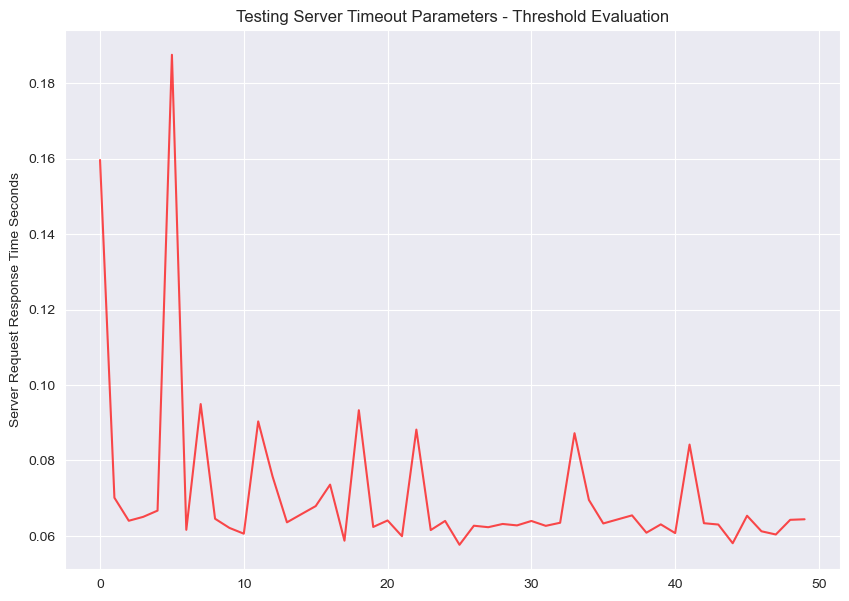

In [6]:
plt.figure(figsize=(10,7))
sns.set_style('darkgrid')
sns.lineplot(x=threshold.index,y=threshold['Server Request Response Time Seconds'], color = "red", alpha = 0.7).set(title="Testing Server Timeout Parameters - Threshold Evaluation")